# Часть 1

In [1]:
import requests

In [2]:
TOKEN = 'c44329c41a60efb54924ff9114b1991b92387152faa97d4bdc8b62cc27fb07f612ec86b9182c759d97e3c'

## Сначала достанем id пользователей, чьи профили открыты,  не удалены и не забанены

Программа заносит в список id пользователей, с которыми мы будем работать в дальнейшем, поскольку их профили открыты, не забанены и не удалены, соответственно, скорее всего на их стене есть посты. Итерация осуществляется с пользователя с id 2104080 по id 2107000, лучше взять больше пользователей, потому что у многих сейчас закрыты профили

In [3]:
# использовала time, когда меня блочили, но это происходило не каждый раз, когда я запускала прогу ¯\_(ツ)_/¯
import time  
from tqdm import tqdm 

user_ids = []  #  список с id пользователей
sex = []  #  пол 


for i in tqdm(range(2104080, 2105000)):  #  для итерации по id пользователей
    data = requests.get(
        'https://api.vk.com/method/users.get', 
        params={
            "user_ids": i,
            'count': 50,
            "fields" : 'sex',
            "v":"5.92",
            "access_token": TOKEN
        
        }
        ).json()

    time.sleep(1)  #  чтобы не было 6 ошибки
    
    try:
        if data['response'][0]['first_name'] != 'DELETED' :  #  проверка, что страница существует
            if data['response'][0]['is_closed'] != True:  #  проверка, что профиль открыт
                
                user_ids.append(data['response'][0]['id'])
                sex.append(data['response'][0]['sex'])
                  
                
        else:
             pass
            
    except KeyError:  
        pass
    
    


100%|██████████| 920/920 [17:30<00:00,  1.14s/it]


In [4]:
len(user_ids) # посмотрим, сколько у нас пользователей 

474

In [6]:
len(sex)  # проверим, что пол указан у всех

474

## Теперь обкачаем стену каждого из пользователя

Программа осуществляет итерацию по списку с id пользователей из предыдущей программы, достает текст поста, время, количество лайков, количество репостов и заносит их в соответствующие списки. 

In [11]:
from datetime import datetime

In [13]:
q = 0  #  счетчик для итерации по индексам в списке user_ids

posts = []  #  записи со стены
times = []  #  время
likes = []  #  количество лайков
reposts = []  #  количество репостов
owner = []  #  user_ids


for user in tqdm(range(len(user_ids))): 
    
    data = requests.get(
        'https://api.vk.com/method/wall.get', 
        params={
            "owner_id": user_ids[q], 
            "count": 30,
            "filter": "owner",   #  взять только записи, оставленные владельцем страницы
            "extended": 1,  
            "v":"5.92",
            "access_token": TOKEN
        
                }
         ).json()
    
    time.sleep(1)  #  избежать слишком много запросов в секунду

    try:
        if data['response']['count'] != 0:  
            s = 0  # счетчик для итерации по индексам
            while s < 30:
                try:
                    if data['response']['items'][s]['text'] != '':  #  пустые тексты не нужны
                        
                        posts.append(data['response']['items'][s]['text'])  #  текст  поста
                        
                        unixtime = data['response']['items'][s]['date']  
                        utc = str(datetime.fromtimestamp(unixtime))
                        times.append(utc)  #  запишем время 
                        
                        likes.append(data['response']['items'][s]['likes']['count'])  #  количество лайков
                        
                        reposts.append(data['response']['items'][s]['reposts']['count'])  #  количество репостов
                        
                        owner.append(data['response']['items'][s]['owner_id'])
                        
                
                        s = s + 1
                        
                    else:
                        s = s + 1
                        
                except IndexError:  #  избежать IndexError
                    s = s + 1
    except KeyError:  #  избежать KeyError
            pass
            
    
    
    q = q + 1

100%|██████████| 474/474 [10:33<00:00,  1.34s/it]


In [151]:
len(posts)  #  посмотрим, сколько текстов

3119

# Часть 2

## Лемматизируем каждый пост

In [152]:
from pymystem3 import Mystem

In [153]:
m = Mystem()

In [154]:
s = 0  #  счетчик
lems = []  #  леммы

while s < len(posts):
    for post in posts:
        lemmas = m.lemmatize(posts[s])
        lems.append(''.join(lemmas))  #  соберем обратно 
        s = s + 1

In [155]:
lems[0]  #  посмотрим, все ли ок

'никогда не пропускать концерт ддт в москва. а в этот год пропускать из-за учеба!\nпоехать вот в казань послушать «история звук», очень круто. обязательно сходить если еще не. правда, не сыграть «предчувствие гражданский война» и «правда на правда», который играть в москва. немного жаль что не послушать вживый этот песня, но все-равный это наверное хороший программа ддт за последний год\n'

## Очистим от стоп-слов 

In [156]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# загружаем нужный список стоп-слов
sw = stopwords.words('russian')

In [157]:
s = 0  #  счетчик
filtered = []  #  текст без стоп-слов

while s < len(lems):
    for lemma in lems:
        words = [w.lower() for w in word_tokenize(lems[s]) if w.isalpha()]
        filt = [w for w in words if w not in sw]
        filtered.append(filt)
        s = s + 1

In [158]:
filtered[0][0:7]  #  посмотрим, все ли ок

['пропускать', 'концерт', 'ддт', 'москва', 'год', 'пропускать', 'учеба']

## Изменим формат данных лемматизированного текста, чтобы не возникало ошибки при внесении в БД

In [159]:
filtered_ok = []
s = 0
while s< len(filtered):
    for i in range(len(filtered)):
        filtered_ok.append(str(filtered[s]))  
        s += 1

In [160]:
filtered_ok[0]  #  посмотрим, все ли ок

"['пропускать', 'концерт', 'ддт', 'москва', 'год', 'пропускать', 'учеба', 'поехать', 'казань', 'послушать', 'история', 'звук', 'очень', 'круто', 'обязательно', 'сходить', 'правда', 'сыграть', 'предчувствие', 'гражданский', 'война', 'правда', 'правда', 'который', 'играть', 'москва', 'немного', 'жаль', 'послушать', 'вживый', 'песня', 'это', 'наверное', 'хороший', 'программа', 'ддт', 'последний', 'год']"

## Создадим DataFrame  для таблицы с текстами

Но сначала для удобства создадим списки с годом, месяцем и днем поста, поскольку эти параметры потом нужны будут для анализа данных по графикам

In [161]:
q = 0  #  счетчик
year = []
month = []
day = [] 

while q < len(times):
    for i in range(len(times)):
        year.append(str(times[q][:4]))  #  год
        month.append(str(times[q][5:7]))  #  месяц
        day.append(str(times[q][8:10]))  #  день
        q = q + 1

In [162]:
import pandas as pd

In [163]:
df1 = pd.DataFrame({
    'id' : owner,
    'texts': posts,
    'lemmas' : filtered_ok,
    'time': times,
    'year': year,
    'month' : month,
    'day': day,
    'liked' : likes,
    'reposted' : reposts,
                  })
df1.head(10)

,id,texts,lemmas,time,year,month,day,liked,reposted
0,2104080,Никогда не пропускаю концерты ДДТ в Москве. А ...,"['пропускать', 'концерт', 'ддт', 'москва', 'го...",2017-12-14 03:17:09,2017,12,14,87,2
1,2104080,"Выпустился из университета Глазго, специальнос...","['выпуститься', 'университет', 'глазго', 'спец...",2017-12-01 23:27:18,2017,12,01,192,1
2,2104080,Провели конгресс муниципальных кандидатов. Уже...,"['проводить', 'конгресс', 'муниципальный', 'ка...",2017-04-30 05:12:44,2017,04,30,67,3
3,2104081,Толковый словарь новонахичеванского диалекта и...,"['толковый', 'словарь', 'новонахичеванский', '...",2019-07-26 19:21:30,2019,07,26,3,0
4,2104081,http://vk.com/tanki_online,['http'],2014-06-24 23:09:58,2014,06,24,2,0
5,2104081,http://support.kaspersky.ru/viruses/deblocker,['http'],2011-01-23 16:50:25,2011,01,23,1,0
6,2104083,Да там была жесть!,['жесть'],2015-11-09 23:33:32,2015,11,09,0,0
7,2104091,"В темноте, слепец - самый надёжный проводник. ...","['темнота', 'слепец', 'самый', 'надежный', 'пр...",2020-03-28 23:23:22,2020,03,28,23,3
8,2104091,Благодарю сердечно Вас друзья и родные за позд...,"['благодарить', 'сердечно', 'друг', 'родные', ...",2019-10-06 20:51:05,2019,10,06,3,0
9,2104091,Respect ; ),['respect'],2019-04-25 15:00:52,2019,04,25,16,1


## Создадим DataFrame  для таблицы с пользователями

Сначала сделаем более удобную запись пола - 'м' и 'ж', вместо 2 и 1

In [164]:
q = 0
gender = []
while q < len(sex):
    for i in sex:
        if sex[q] == 2:
            gender.append('м')
            q +=1
        else:
            gender.append('ж')
            q+=1
len(gender)

474

In [165]:
df = pd.DataFrame({
    'users': user_ids,
    'gender' : gender,

                  })
df.head(2)

,users,gender
0,2104080,м
1,2104081,м


## Занесем в базу данных 

База данных содержит 2 таблицы - text и users. Таблицы связаны по айди пользователей 

In [166]:
import sqlite3
conn = sqlite3.connect('HomeworkApi.db')  

df1.to_sql( 'texts' , conn, if_exists='replace')
c = conn.cursor()
c.execute('''  SELECT * FROM texts
         ''')

df.to_sql( 'users' , conn, if_exists='replace')
c = conn.cursor()
c.execute('''  SELECT * FROM users
         ''')

conn.commit()

# Часть 3

Я построила немного больше графиков, чем нужно, потому что графики 4 и 5 были простыми, но я их оставила, потому что визуализация очень красивая. Всего 7 графиков, последний из них с запросом к БД

## Построим графики

In [167]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### График 1

Посмотрим, как зависит количество лайков от репостов. Ожидается, что чем больше репостов, тем больше лайков

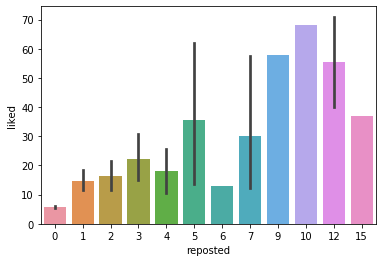

In [168]:
sns.barplot(x="reposted", y="liked", data=df1);

Гипотеза не совсем подтвердилась, ожидалось, что наибольшее количество лайков будет у постов с 15 репостами, но обычно лайков больше у постов с 10 репостами. Однако, если посмотреть в среднем, то посты с < 5 репостами собирают обычно меньше лайков, чем те, где репостов >=5 (кроме 6, но это, скорее, просто в выборке так вышло)

### График 2

Узнаем, как зависит количество репостов от года в нашей выборке, интересно посмотреть, на какой год приходится наибольшее количество репостов 

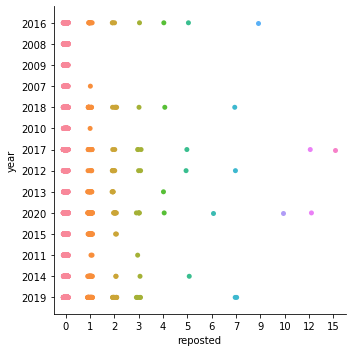

In [169]:
sns.catplot(x="reposted", y="year", data=df1);

Как видно из графика, наибольшее количество репостов (15) было в 2017 году. 

### График 3

Посмотрим на то, как зависит количество лайков от месяца публикации поста, сгруппируем по месяцу

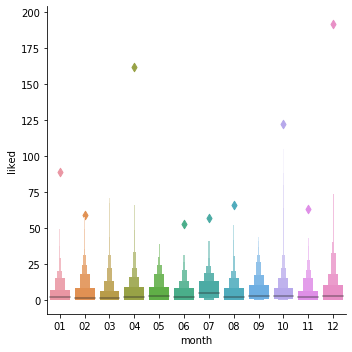

In [170]:
sns.catplot(x="month", y="liked", kind="boxen",
            data=df1.sort_values("month"));

Можно заметить, что выбросы есть почти в каждом месяце года, особенно заметные в апреле и декабре

### Графики 4 и 5

Посмотрим график по дням и месяцам (еще эти графики очень красивые)

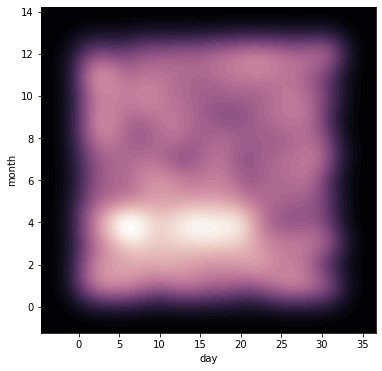

In [171]:
f, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df1['day'], df1['month'], cmap=cmap, n_levels=60, shade=True);

Больше всего пересечений приходится примерно на 15 день 4 месяца

То же, но с другим дизайном:

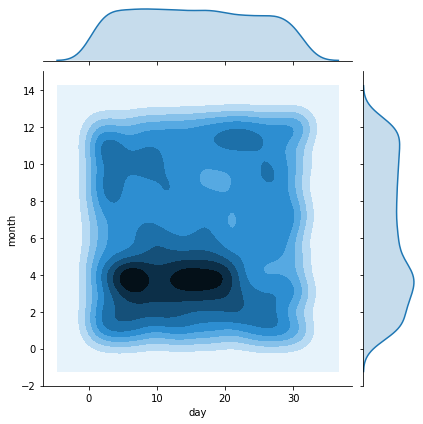

In [172]:
sns.jointplot(x="day", y="month", data=df1, kind="kde");

### График 6

Построим вордклауд

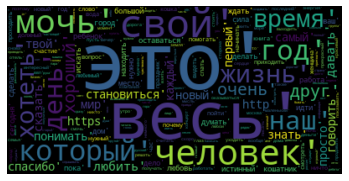

In [173]:
from wordcloud import WordCloud

w = []  #  словарь для лемм
q = 0
text = df1['lemmas']

while q < len(text):
    for i in text:
        w.append(text[q])
        q += 1
        
a = str(w)
wordcloud = WordCloud().generate(a)
# отобразим вордклауд
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### График 7

Построим зависимость количества лайков, сгруппировав по id

In [174]:
import sqlite3
lik = []
conn = sqlite3.connect('HomeworkApi.db')
for row in c.execute('SELECT liked FROM texts GROUP BY id'):
    lik.append(row)

In [175]:
len(lik)

314

In [176]:
#  проверка id
q = 0
a = []
while q < len(user_ids):
    for i in sex:
        if user_ids[q] in owner:
            a.append(sex[q])
            q +=1
        else:
            
            q+=1
len(a)   

314

In [177]:
df4 = pd.DataFrame({
    'лайки': lik,
    'пол' : a,

                  })
df4.head(2)

,лайки,пол
0,"(87,)",2
1,"(3,)",2


In [1]:
sns.catplot(x="gender", y="likes", size=7,
            data=df4.sort_values("gender"));

NameError: name 'sns' is not defined